In [100]:
from porn_audios_detector import predict_audio_of_video,clear_none_from_predictions
from porn_images_detector import predict_image_video
import tensorflow as tf
from tensorflow.keras.models import load_model
from IPython.display import clear_output
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import os

In [2]:
image_model_path= r'A:\AI DB\LSPD\models\3ModaforImagesFromVideosV2.keras'
audio_model_path= r'A:\AI DB\LSPD\models\audioModelUnfreeze.keras'
audio_model = load_model(audio_model_path)
image_model = load_model(image_model_path)

In [107]:
def predict_video(video_path, image_model,audio_model,
                             images_interval=1, void_threshold=1, 
                             image_sensibility=0.9, audio_sensibility=0.98,
                             threshold=0.15,x=''):
    start_time = time.time()
    clear_output(wait=True)
    print(x)
    audio_result = predict_audio_of_video(video_path,audio_model,
                                                frame_duration=0.96, 
                                                sensibility=audio_sensibility, 
                                                threshold=threshold, void_threshold=void_threshold, audio_threshold=-50)
    image_result = predict_image_video(video_path, image_model, 
                                                            interval=images_interval, void_threshold=void_threshold,
                                                            sensibility=image_sensibility,
                                                            threshold=threshold)
    elapsed_time = time.time() - start_time
    #print(x)
    print(f"Total time: {elapsed_time:.2f} seconds.")
    return image_result , audio_result
    

In [95]:
def merge_intervals(intervals1, intervals2):
    # Combine and sort intervals by start time
    intervals = sorted(intervals1 + intervals2, key=lambda x: x[0])
    
    merged = []
    for interval in intervals:
        if not merged or merged[-1][1] < interval[0]:
            merged.append(interval)
        else:
            merged[-1] = (merged[-1][0], max(merged[-1][1], interval[1]))
    
    return merged

def intersect_intervals(intervals1, intervals2):
    i, j = 0, 0
    intersection = []
    
    while i < len(intervals1) and j < len(intervals2):
        start1, end1 = intervals1[i]
        start2, end2 = intervals2[j]
        
        # Check if intervals overlap
        if start1 <= end2 and start2 <= end1:
            intersection.append((max(start1, start2), min(end1, end2)))
        
        # Move to the next interval in the list with the earliest ending interval
        if end1 < end2:
            i += 1
        else:
            j += 1
    
    return intersection

In [5]:
def combine_audio_image_results(image_result , audio_result):
    if audio_result is None :
        return image_result
    return merge_intervals(image_result , audio_result)

In [6]:
def intersections_audio_image_results(image_result , audio_result):
    if audio_result is None :
        return image_result
    return intersect_intervals(image_result , audio_result)

In [16]:
image_result , audio_result = predict_video(r'A:\AI DB\NPDI-2K\tests\porn\vPorn000021.mp4',
                                            image_model = image_model,
                                            audio_model = audio_model,
                                            image_sensibility=0.9, 
                                            audio_sensibility=0.98)


Total time: 1.96 seconds.
Percentage of pornographic audio: 77.17%
Total time: 30.95 seconds.
Percentage of pornographic frames: 83.04%

Total time: 32.91 seconds.


In [25]:
print("audio result :")
if audio_result:
    print(audio_result)
else :
    print('None')
print("image result :")
print(image_result)
print("merged result :")
print(combine_audio_image_results(image_result , audio_result))
print("intersection result :")
print(intersections_audio_image_results(image_result , audio_result))

audio result :
[(0.0, 1.92), (3.84, 108.48), (110.4, 216.0), (217.92, 381.12), (383.04, 1059.84), (1061.76, 1264.8)]
image result :
[(15.0, 18.0), (22.0, 25.0), (36.0, 115.0), (117.0, 125.0), (129.0, 192.0), (195.0, 205.0), (207.0, 245.0), (247.0, 411.0), (413.0, 508.0), (511.0, 580.0), (584.0, 925.0), (927.0, 1035.0), (1037.0, 1095.0), (1097.0, 1181.0), (1184.0, 1266.0)]
merged result :
[(0.0, 1.92), (3.84, 1266.0)]
intersection result :
[(15.0, 18.0), (22.0, 25.0), (36.0, 108.48), (110.4, 115.0), (117.0, 125.0), (129.0, 192.0), (195.0, 205.0), (207.0, 216.0), (217.92, 245.0), (247.0, 381.12), (383.04, 411.0), (413.0, 508.0), (511.0, 580.0), (584.0, 925.0), (927.0, 1035.0), (1037.0, 1059.84), (1061.76, 1095.0), (1097.0, 1181.0), (1184.0, 1264.8)]


In [7]:
def print_result(predictions,trueLabels,label):
    cm = confusion_matrix(trueLabels, predictions)
    
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Generate a classification report
    cr = classification_report(trueLabels, predictions, digits=4)
    print("Classification Report:\n", cr)
    
    # Calculate accuracy score
    accuracy = accuracy_score(trueLabels, predictions)
    print("Accuracy Score:", format(accuracy, '.4f'))
    
    # Calculate F1 score
    f1 = f1_score(trueLabels, predictions)
    print("F1 Score:", format(f1, '.4f'))
    
    # Plot the confusion matrix with annotations positioned at the bottom
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'], annot_kws={'size': 16})
    
    # Add custom annotations at the bottom of each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.2, '{:.2f}%'.format(cm_normalized[i, j] * 100), ha='center', va='bottom', color='black', fontsize=14)

    title='Matrice de confusion : '+label
    plt.ylabel('Réel', fontsize=12)
    plt.xlabel('Prédit', fontsize=12)
    plt.title(title, fontsize=16)
    plt.show()

In [8]:
def test_videos_pourcentage(normal_directory, porn_directory,
                            image_model,audio_model,
                             images_interval=1, void_threshold=1, 
                             image_sensibility=0.9, audio_sensibility=0.98,
                             threshold=0.15,
                           percentage=1):
    start_time = time.time()
    np.random.seed(69)  # For reproducibility

    normal_videos = [filename for filename in os.listdir(normal_directory) if filename.endswith(".mp4")]
    porn_videos = [filename for filename in os.listdir(porn_directory) if filename.endswith(".mp4")]

    # Determine the number of videos to test based on the given percentage
    num_normal_videos_to_test = int(len(normal_videos) * percentage)
    num_porn_videos_to_test = int(len(porn_videos) * percentage)

    # Randomly select videos to test
    normal_videos_to_test = np.random.choice(normal_videos, num_normal_videos_to_test, replace=False)
    porn_videos_to_test = np.random.choice(porn_videos, num_porn_videos_to_test, replace=False)

    all_videos = [(video, 0, os.path.join(normal_directory, video)) for video in normal_videos_to_test] + \
                 [(video, 1, os.path.join(porn_directory, video)) for video in porn_videos_to_test]

    video_union_results = []
    video_intersection_results = []
    image_results = []
    audio_results = []
    true_labels = []
    mismatches = []

    total_videos = len(all_videos)
    progress_message = f"Processed 0/{total_videos} videos (0.00%)"
    for idx, (video_file, label, video_path) in enumerate(all_videos):
        image_result , audio_result = predict_video(video_path,
                                            image_model = image_model,
                                            audio_model = audio_model,
                                            image_sensibility=0.9, 
                                            audio_sensibility=0.98,x=progress_message)
        
        union_result=combine_audio_image_results(image_result , audio_result)
        intersect_result=intersections_audio_image_results(image_result , audio_result)
        
        if len(union_result)>0:
            video_union_results.append(1)
        else:
            video_union_results.append(0)

        if len(intersect_result)>0:
            video_intersection_results.append(1)
        else:
            video_intersection_results.append(0)

        if len(image_result)>0:
            image_results.append(1)
        else:
            image_results.append(0)

        if audio_result is None :
            audio_results.append(0)
        else :
            if len(audio_result)>0 :
                audio_results.append(1)
            else:
                audio_results.append(0)

        
        true_labels.append(label)

        # Print progress
        progress_percentage = ((idx + 1) / total_videos) * 100
        clear_output(wait=True)
        progress_message = f"Processed {idx + 1}/{total_videos} videos ({progress_percentage:.2f}%)"
        #print(progress_message)
        # Check for mismatch
        if video_union_results[-1] != true_labels[-1]:
            mismatches.append((video_file, video_union_results[-1], true_labels[-1]))

    if mismatches:
        print("Videos with mismatched results (video_union_results):")
        for mismatch in mismatches:
            print(f"Video: {mismatch[0]}, Predicted: {mismatch[1]}, True Label: {mismatch[2]}")
    
    elapsed_time = time.time() - start_time
    print(f"Total time: {elapsed_time:.2f} seconds.")

    return video_union_results,video_intersection_results,image_results,audio_results,true_labels

In [9]:
lspd_porn=r'A:\AI DB\LSPD_test_videosSplited\porn'
lspd_normal=r'A:\AI DB\LSPD_test_videosSplited\normal'

npdi_porn=r'A:\AI DB\NPDI_test_videosSplited\porn'
npdi_normal=r'A:\AI DB\NPDI_test_videosSplited\normal'

my_dataset_porn=r'A:\AI DB\MYDATASET_Splited\porn'
my_dataset_normal=r'A:\AI DB\MYDATASET_Splited\normal'

In [27]:
video_union_results,video_intersection_results,image_results,audio_results,true_labels=test_videos_pourcentage(lspd_normal, lspd_porn,
                                image_model = image_model,
                                audio_model = audio_model,
                                  images_interval=1, void_threshold=1, 
                                   image_sensibility=0.9, audio_sensibility=0.98,
                                    threshold=0.15,
                                     percentage=1)


Videos with mismatched results (video_union_results):
Video: nonporn_253_part2.mp4, Predicted: 1, True Label: 0
Video: nonporn_253_part3.mp4, Predicted: 1, True Label: 0
Total time: 4110.27 seconds.


Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9775    0.9886        89
           1     0.9851    1.0000    0.9925       132

    accuracy                         0.9910       221
   macro avg     0.9925    0.9888    0.9906       221
weighted avg     0.9911    0.9910    0.9909       221

Accuracy Score: 0.9910
F1 Score: 0.9925


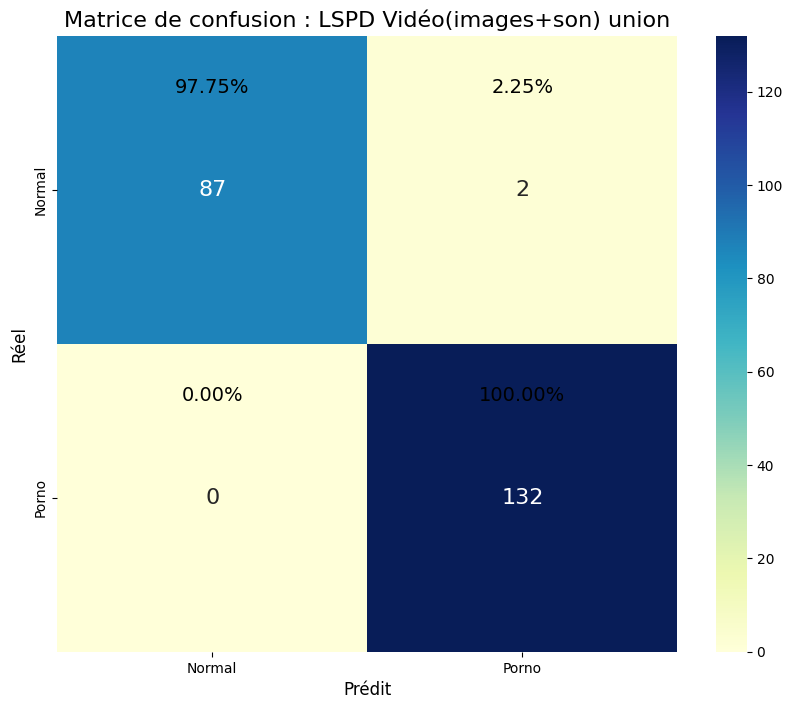

In [28]:
print_result(video_union_results,true_labels,'LSPD Vidéo(images+son) union')

Classification Report:
               precision    recall  f1-score   support

           0     0.7607    1.0000    0.8641        89
           1     1.0000    0.7879    0.8814       132

    accuracy                         0.8733       221
   macro avg     0.8803    0.8939    0.8727       221
weighted avg     0.9036    0.8733    0.8744       221

Accuracy Score: 0.8733
F1 Score: 0.8814


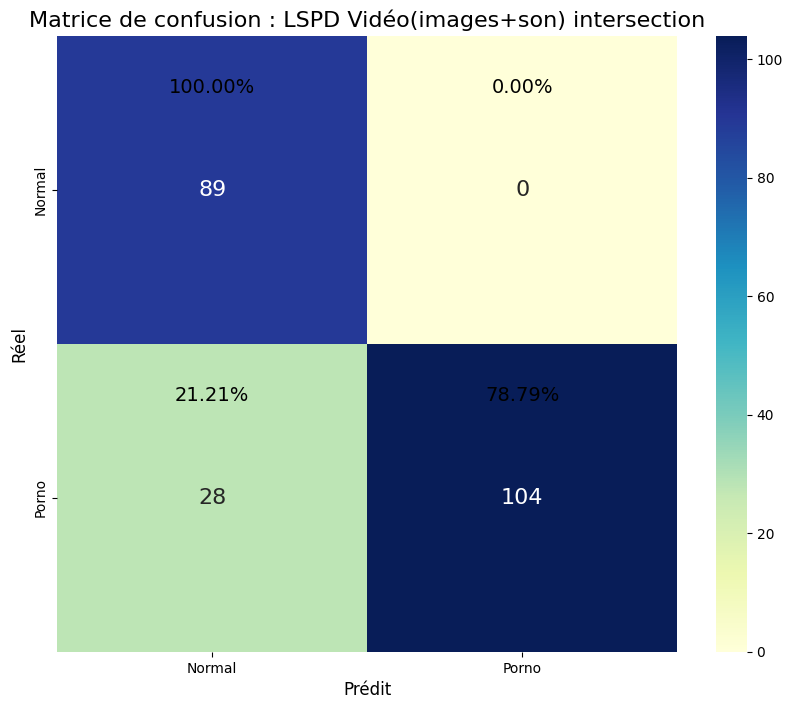

In [29]:
print_result(video_intersection_results,true_labels,'LSPD Vidéo(images+son) intersection')

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9775    0.9886        89
           1     0.9851    1.0000    0.9925       132

    accuracy                         0.9910       221
   macro avg     0.9925    0.9888    0.9906       221
weighted avg     0.9911    0.9910    0.9909       221

Accuracy Score: 0.9910
F1 Score: 0.9925


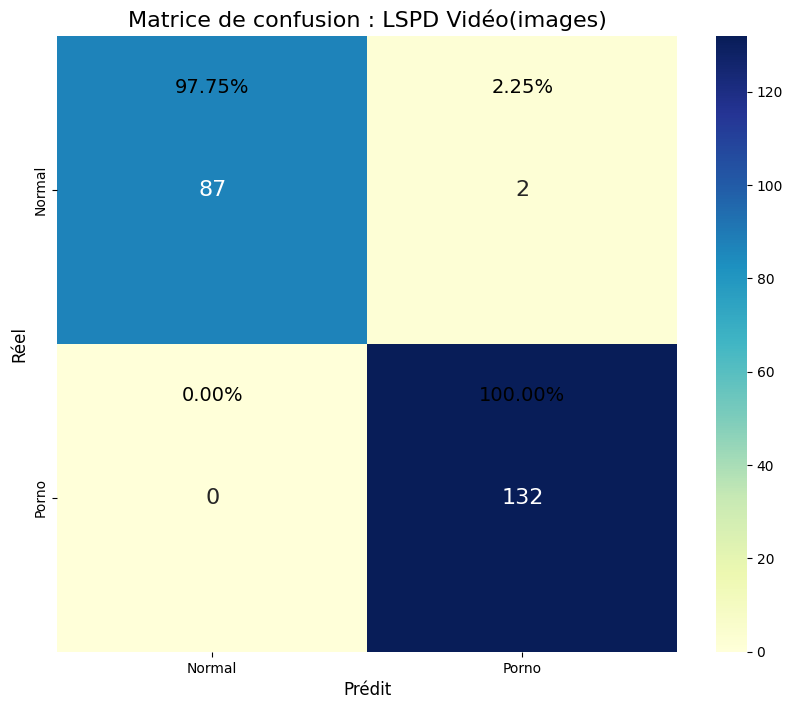

In [30]:
print_result(image_results,true_labels,'LSPD Vidéo(images)')

In [31]:
audio_results,truelabels=clear_none_from_predictions(audio_results,true_labels)

Classification Report:
               precision    recall  f1-score   support

           0     0.6953    1.0000    0.8203        89
           1     1.0000    0.7045    0.8267       132

    accuracy                         0.8235       221
   macro avg     0.8477    0.8523    0.8235       221
weighted avg     0.8773    0.8235    0.8241       221

Accuracy Score: 0.8235
F1 Score: 0.8267


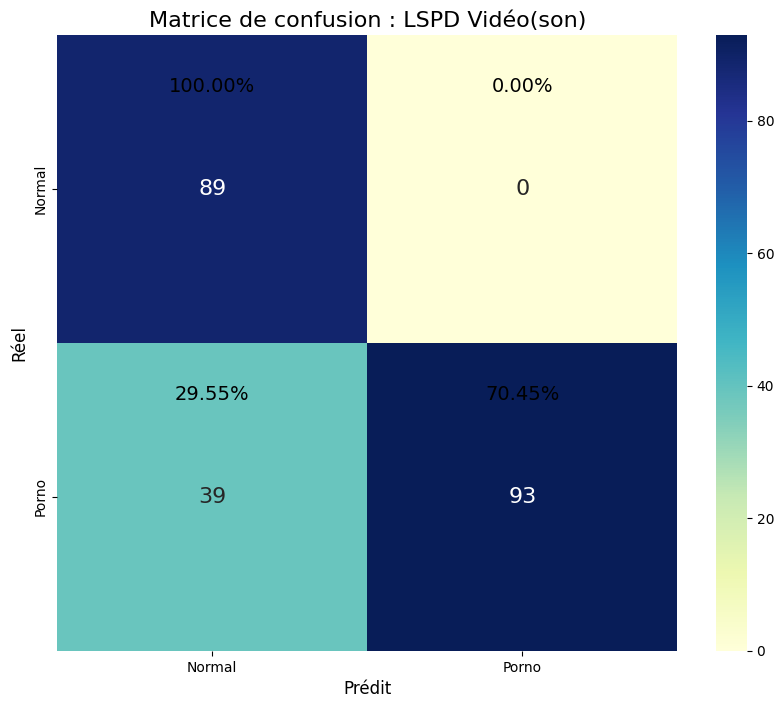

In [32]:
print_result(audio_results,truelabels,'LSPD Vidéo(son)')

In [33]:
video_union_results1,video_intersection_results1,image_results1,audio_results1,true_labels1=test_videos_pourcentage(npdi_normal, npdi_porn,
                                image_model = image_model,
                                audio_model = audio_model,
                                  images_interval=1, void_threshold=1, 
                                   image_sensibility=0.9, audio_sensibility=0.98,
                                    threshold=0.15,
                                     percentage=1)

Videos with mismatched results (video_union_results):
Video: vNonPorn000007_part1.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000096_part5.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000097_part3.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000148_part2.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000004_part1.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000050_part1.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000118_part1.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000171_part4.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000030_part1.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000007_part4.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000043_part2.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000017_part1.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000067_part5.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000109_part4.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000067_part1.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000049_part4.mp4

Classification Report:
               precision    recall  f1-score   support

           0     0.9959    0.7869    0.8791       305
           1     0.8778    0.9979    0.9340       468

    accuracy                         0.9146       773
   macro avg     0.9368    0.8924    0.9066       773
weighted avg     0.9244    0.9146    0.9123       773

Accuracy Score: 0.9146
F1 Score: 0.9340


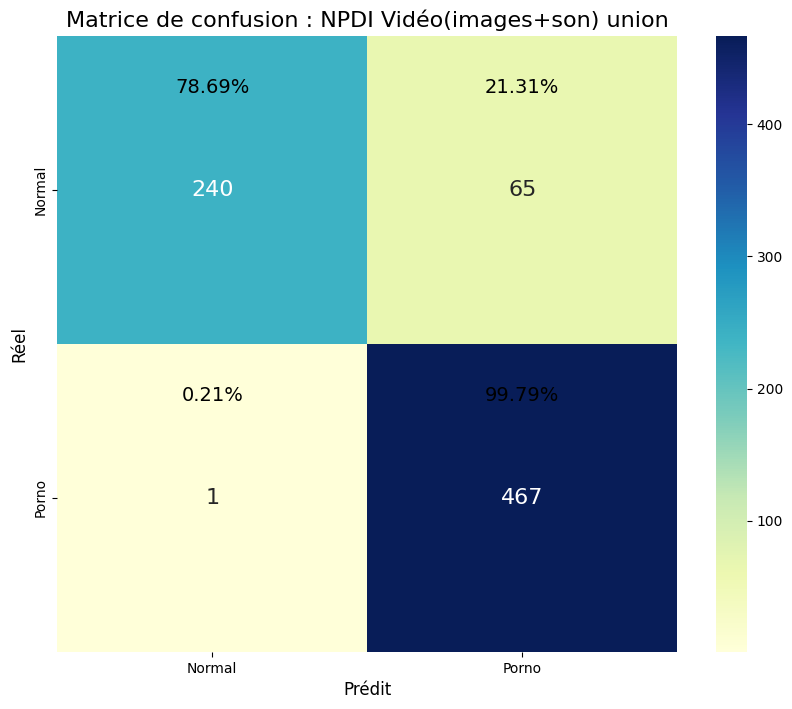

In [34]:
print_result(video_union_results1,true_labels1,'NPDI Vidéo(images+son) union')

Classification Report:
               precision    recall  f1-score   support

           0     0.8915    0.9967    0.9412       305
           1     0.9977    0.9209    0.9578       468

    accuracy                         0.9508       773
   macro avg     0.9446    0.9588    0.9495       773
weighted avg     0.9558    0.9508    0.9512       773

Accuracy Score: 0.9508
F1 Score: 0.9578


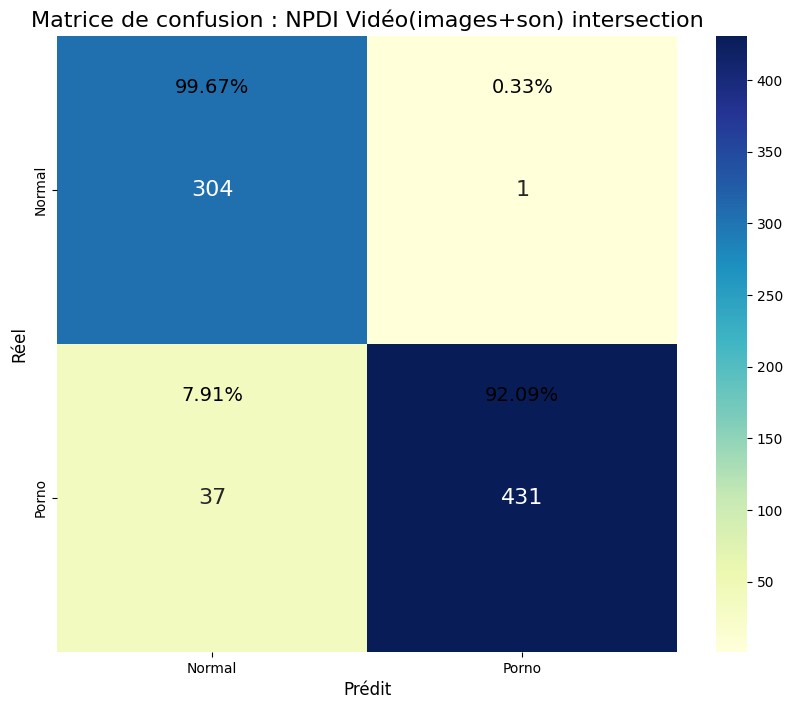

In [35]:
print_result(video_intersection_results1,true_labels1,'NPDI Vidéo(images+son) intersection')

Classification Report:
               precision    recall  f1-score   support

           0     0.9867    0.9705    0.9785       305
           1     0.9810    0.9915    0.9862       468

    accuracy                         0.9832       773
   macro avg     0.9838    0.9810    0.9823       773
weighted avg     0.9832    0.9832    0.9832       773

Accuracy Score: 0.9832
F1 Score: 0.9862


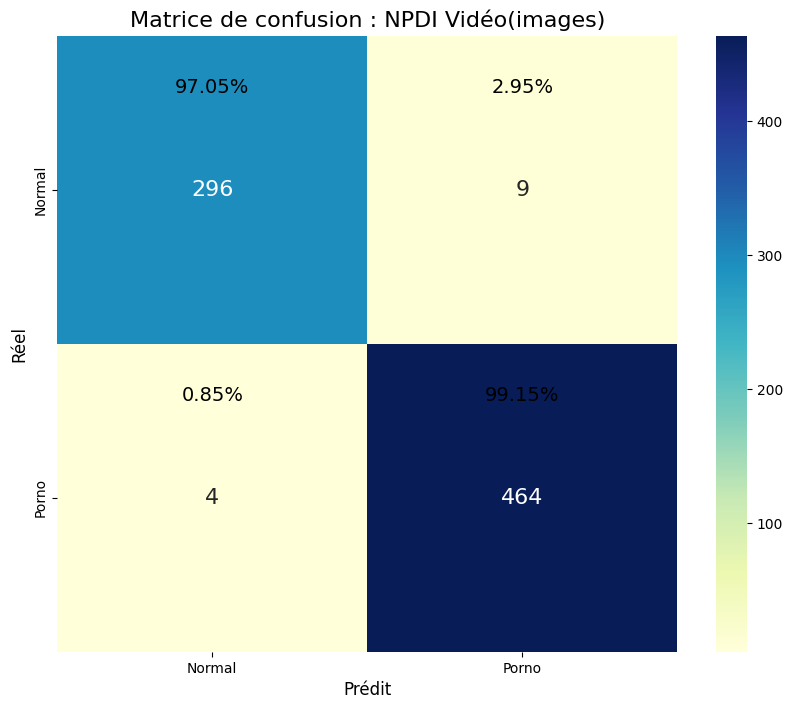

In [36]:
print_result(image_results1,true_labels1,'NPDI Vidéo(images)')

In [37]:
audio_results1,truelabels1=clear_none_from_predictions(audio_results1,true_labels1)

Classification Report:
               precision    recall  f1-score   support

           0     0.8794    0.8131    0.8450       305
           1     0.8839    0.9274    0.9051       468

    accuracy                         0.8823       773
   macro avg     0.8817    0.8702    0.8750       773
weighted avg     0.8821    0.8823    0.8814       773

Accuracy Score: 0.8823
F1 Score: 0.9051


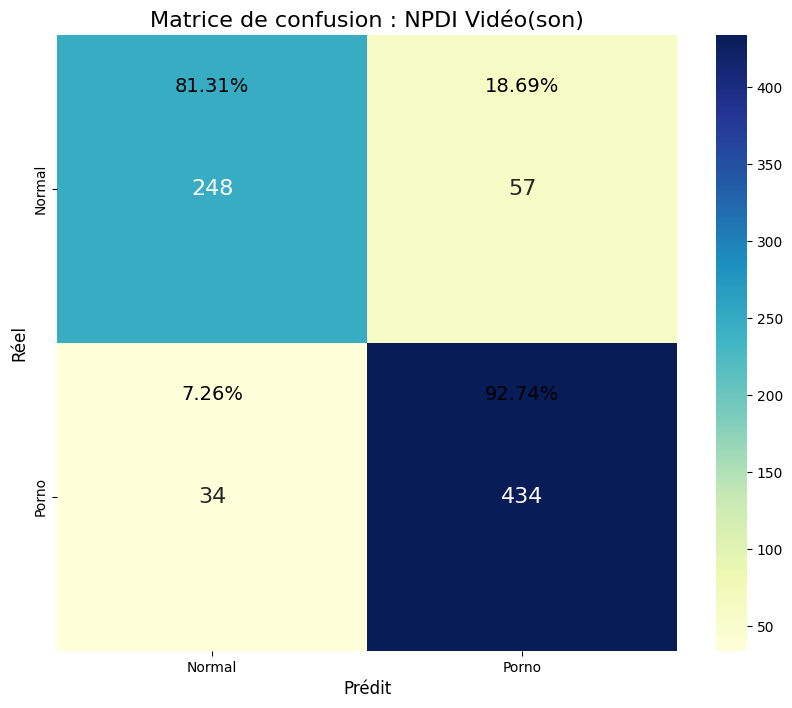

In [38]:
print_result(audio_results1,truelabels1,'NPDI Vidéo(son)')

In [39]:
video_union_results2,video_intersection_results2,image_results2,audio_results2,true_labels2=test_videos_pourcentage(my_dataset_normal, my_dataset_porn,
                                image_model = image_model,
                                audio_model = audio_model,
                                  images_interval=1, void_threshold=1, 
                                   image_sensibility=0.9, audio_sensibility=0.98,
                                    threshold=0.15,
                                     percentage=1)

Videos with mismatched results (video_union_results):
Video: yt5s.com-طيموشة الحلقة 01HD Timoucha_part9.mp4, Predicted: 1, True Label: 0
Video: videoplayback_part24.mp4, Predicted: 1, True Label: 0
Video: yt5s.com-طيموشة الحلقة 01HD Timoucha_part14.mp4, Predicted: 1, True Label: 0
Video: videoplayback_part27.mp4, Predicted: 1, True Label: 0
Total time: 9540.59 seconds.


Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9758    0.9877       165
           1     0.9791    1.0000    0.9894       187

    accuracy                         0.9886       352
   macro avg     0.9895    0.9879    0.9886       352
weighted avg     0.9889    0.9886    0.9886       352

Accuracy Score: 0.9886
F1 Score: 0.9894


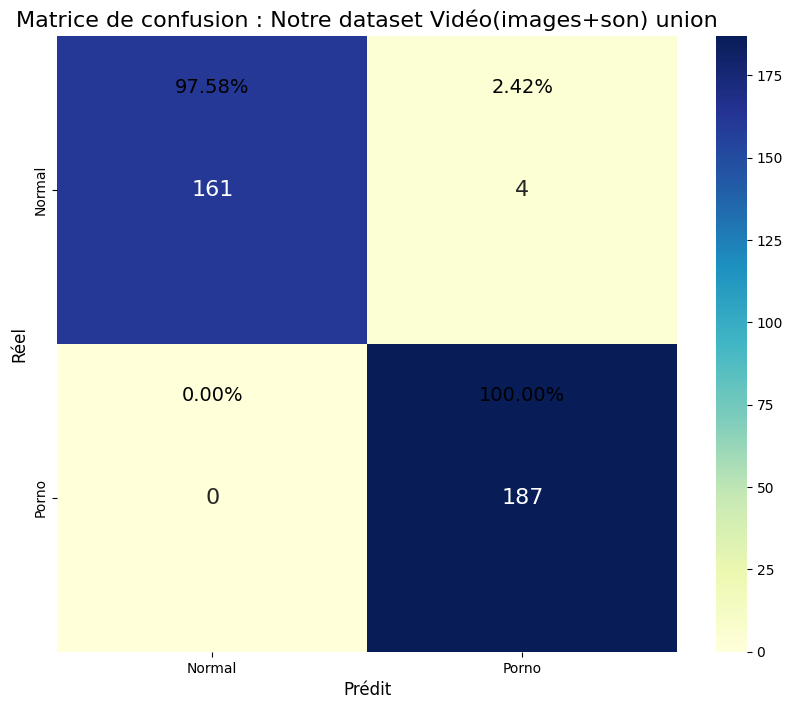

In [40]:
print_result(video_union_results2,true_labels2,'Notre dataset Vidéo(images+son) union')

Classification Report:
               precision    recall  f1-score   support

           0     0.9218    1.0000    0.9593       165
           1     1.0000    0.9251    0.9611       187

    accuracy                         0.9602       352
   macro avg     0.9609    0.9626    0.9602       352
weighted avg     0.9633    0.9602    0.9603       352

Accuracy Score: 0.9602
F1 Score: 0.9611


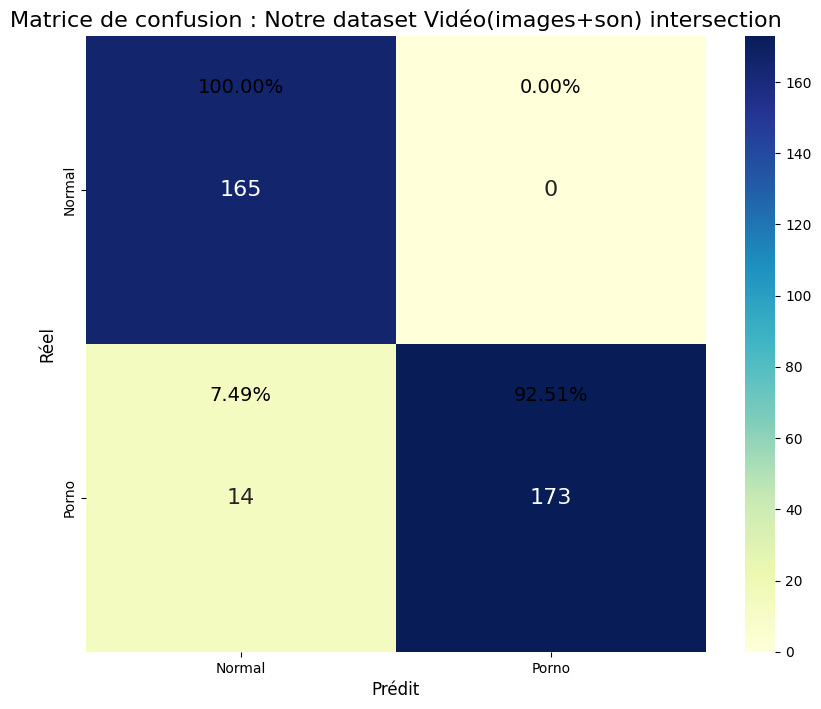

In [41]:
print_result(video_intersection_results2,true_labels2,'Notre dataset Vidéo(images+son) intersection')

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9879    0.9939       165
           1     0.9894    1.0000    0.9947       187

    accuracy                         0.9943       352
   macro avg     0.9947    0.9939    0.9943       352
weighted avg     0.9944    0.9943    0.9943       352

Accuracy Score: 0.9943
F1 Score: 0.9947


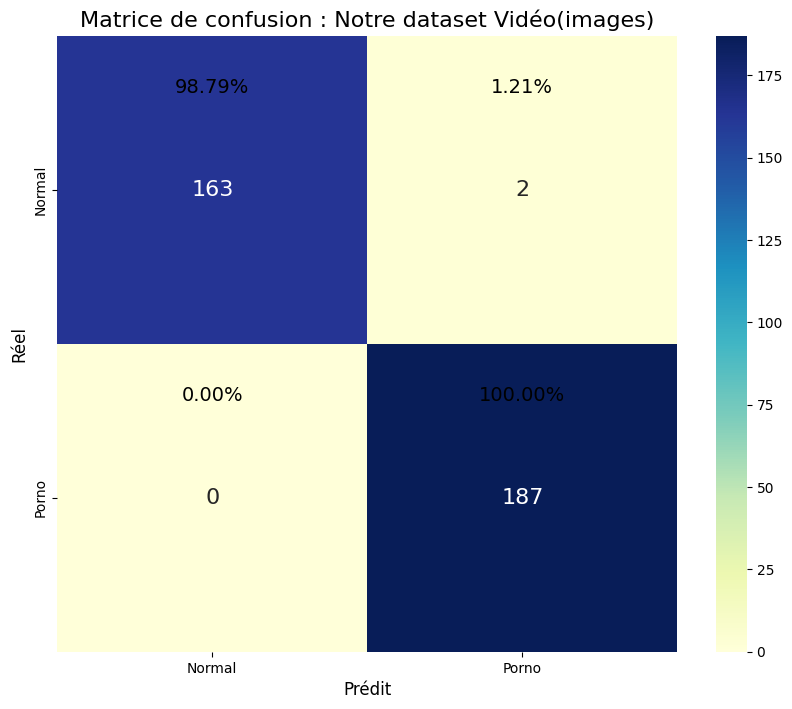

In [42]:
print_result(image_results2,true_labels2,'Notre dataset Vidéo(images)')

In [43]:
audio_results2,truelabels2=clear_none_from_predictions(audio_results2,true_labels2)

Classification Report:
               precision    recall  f1-score   support

           0     0.8811    0.9879    0.9314       165
           1     0.9880    0.8824    0.9322       187

    accuracy                         0.9318       352
   macro avg     0.9346    0.9351    0.9318       352
weighted avg     0.9379    0.9318    0.9318       352

Accuracy Score: 0.9318
F1 Score: 0.9322


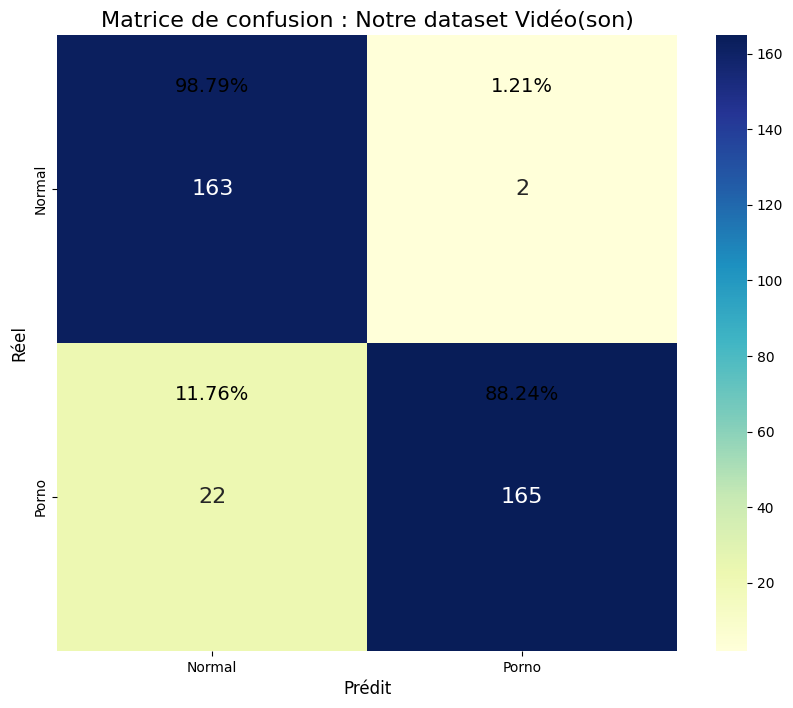

In [44]:
print_result(audio_results2,truelabels2,'Notre dataset Vidéo(son)')

In [48]:
video_union_results_total=[]
video_union_results_total.extend(video_union_results)
video_union_results_total.extend(video_union_results1)
video_union_results_total.extend(video_union_results2)

true_labels_total=[]
true_labels_total.extend(true_labels)
true_labels_total.extend(true_labels1)
true_labels_total.extend(true_labels2)

video_intersection_results_total=[]
video_intersection_results_total.extend(video_intersection_results)
video_intersection_results_total.extend(video_intersection_results1)
video_intersection_results_total.extend(video_intersection_results2)



Classification Report:
               precision    recall  f1-score   support

           0     0.9980    0.8730    0.9313       559
           1     0.9172    0.9987    0.9562       787

    accuracy                         0.9465      1346
   macro avg     0.9576    0.9359    0.9438      1346
weighted avg     0.9507    0.9465    0.9459      1346

Accuracy Score: 0.9465
F1 Score: 0.9562


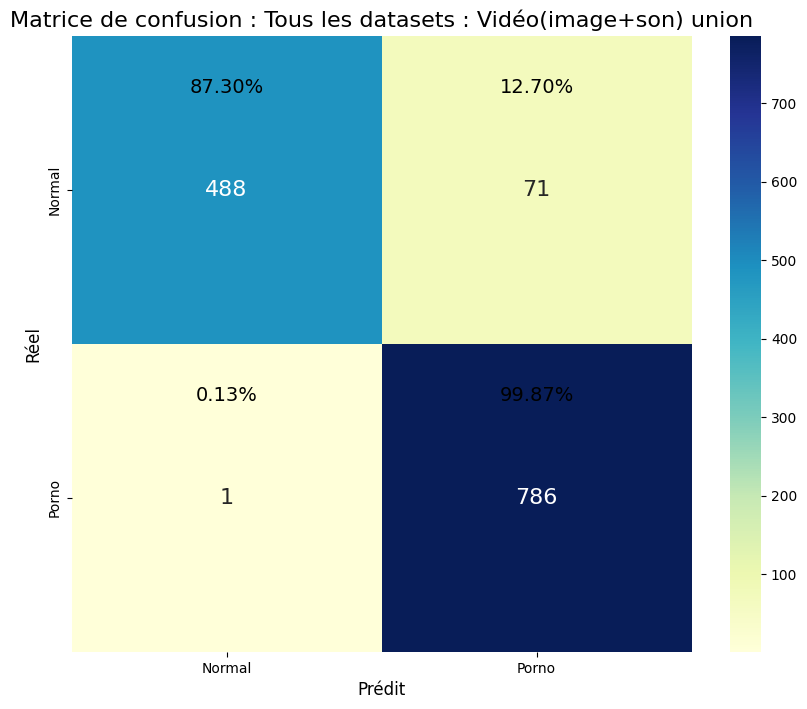

In [50]:
print_result(video_union_results_total,true_labels_total,'Tous les datasets : Vidéo(image+son) union')

Classification Report:
               precision    recall  f1-score   support

           0     0.8760    0.9982    0.9331       559
           1     0.9986    0.8996    0.9465       787

    accuracy                         0.9406      1346
   macro avg     0.9373    0.9489    0.9398      1346
weighted avg     0.9477    0.9406    0.9410      1346

Accuracy Score: 0.9406
F1 Score: 0.9465


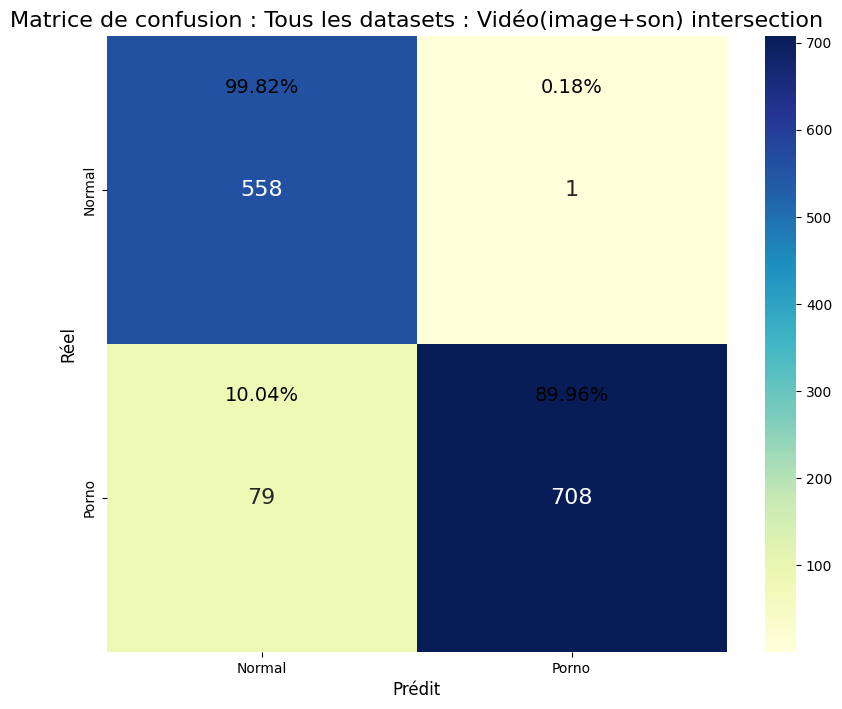

In [51]:
print_result(video_intersection_results_total,true_labels_total,'Tous les datasets : Vidéo(image+son) intersection')

In [83]:
def is_video_file(file_path,video_extensions):
    # Check if the file exists
    if not os.path.exists(file_path):
        message = file_path + ": file does not exist"
        return False,message
    
    # Get the file extension
    _, file_extension = os.path.splitext(file_path)
    
    # Check if the file extension is in the list of video extensions
    if file_extension.lower() in video_extensions:
        return True,None
    else:
        message = file_path + ": file exists but is not a supported extension"
        return False,message

In [114]:
def predict(video_path , image_model , audio_model , option = 3 , verbose = True):
    # args :
    #     video_path : path of the video to predict. tested on : .mp4 .avi (not tested with others, could work).
    #     image_model : image model.
    #     audio_model : sound model.
    #     option : option for how to combine results 
    #         if 3 : return the two results seperatly image/audio (default choice).
    #         if 4 : return two combined results union/intersection.
    #         otherwise, return a single result.
    #         Imges results are more pertinent, may depend on the video content tho 
    #     verbose : True by default, if False, won't print anything
    #
    # return :
    #     Array of pair of tuple where the first element in the tuple represents the start of the detected pornography
    #   and the second element represents the end of the detected pornography
    #   in seconds.
    #     If return is None, there is a problem somewhere, should print it exactly.

    def print_if_verbose(message):
        if verbose:
            print(message)
    
    #check if option is correct
    if option not in (1, 2, 3, 4):
        print_if_verbose('Invalid option...')
        print_if_verbose('Available options are :')
        print_if_verbose('    1 -> union of results.')
        print_if_verbose('    2 -> intersection of results.')
        print_if_verbose('    3 -> seperate results.')
        print_if_verbose('    3 -> union + intersection of results.')
        return None

    #supported extensions 
    #only tested with mp4 and avi but should works with others extensions
    #video_extensions = {'.mp4', '.avi', '.mov', '.mkv', '.flv', '.wmv', '.webm'}
    video_extensions = {'.mp4', '.avi'}
    
    is_video_legit , message =is_video_file(video_path , video_extensions)

    if not is_video_legit :
        print_if_verbose(message)
        return None

    file_name, _ = os.path.splitext(os.path.basename(video_path))

    # sensibilites could be changed, performances will vary
    # if image_result = None : no audio or audio too quiet
    image_result , audio_result = predict_video(video_path,
                                            image_model = image_model,
                                            audio_model = audio_model,
                                            image_sensibility=0.9, 
                                            audio_sensibility=0.98,x=file_name+' :')

    if option == 3 :
        return image_result , audio_result

    intersect_result=intersections_audio_image_results(image_result , audio_result)

    if option == 2 :
        return intersect_result

    union_result=combine_audio_image_results(image_result , audio_result)

    if option == 1 :
        return union_result

    if option == 4 :
        return union_result , intersect_result



In [115]:
a=predict(r'A:\AI DB\MYDATASET_Splited\porn\porn_290_part3.mp4',image_model,audio_model,verbose =False , option=2)
print(a)

porn_290_part3 :
Total time: 2.61 seconds.
Percentage of pornographic audio: 96.00%
Total time: 11.64 seconds.
Percentage of pornographic frames: 105.87%
Total time: 14.28 seconds.
[(0.0, 24.0)]


In [122]:
def predict_directory(directory_path , image_model , audio_model , option = 3 , verbose = True) : 
    # args :
    #     directory_path : path of the directory, will test every file (works only for videos)
    #     image_model : image model.
    #     audio_model : sound model.
    #     option : option for how to combine results 
    #         if 3 : return the two results seperatly image/audio (default choice).
    #         if 4 : return two combined results union/intersection.
    #         otherwise, return a single result.
    #         Imges results are more pertinent, may depend on the video content tho 
    #     verbose : True by default, if False, won't print anything
    #
    # return :
    #     Array of pair of tuple, 
    #         first element is the name of the file, 
    #         second element is the results (depend on option, refer to predict for more informations about results)
    #     If return is None, there is a problem somewhere, should print it exactly.
    
    if not os.path.exists(directory_path):
        if verbose:
            print(f"Directory does not exist: {directory_path}")
        return []

    predictions = []
    
    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)
        
        if os.path.isfile(file_path):
            
            prediction = predict(file_path, image_model, audio_model, option=option, verbose=verbose)
            predictions.append((file_name, prediction))
    
    return predictions

In [121]:
a=predict_directory(r'A:\AI DB\a' , image_model , audio_model , option = 4 , verbose = True)
print(a)

vPorn000090_part5 :
Total time: 1.34 seconds.
Percentage of pornographic audio: 45.45%
Total time: 5.07 seconds.
Percentage of pornographic frames: 60.81%
Total time: 6.44 seconds.
[('porn_199_part2.mp4', ([(0.0, 12.0)], [(0.0, 11.52)])), ('porn_344_part2.mp4', ([(0.0, 11.0)], [])), ('porn_397_part3.mp4', ([(0.0, 14.0)], [])), ('vPorn000090_part5.mp4', ([(0.0, 6.77)], [(0.0, 4.8)]))]
